### Global Variables

In [1]:
from sklearn.preprocessing import LabelEncoder

image_size = 96
num_samples = 5
epochs = 50
label_encoder = LabelEncoder()

### Image Functions

In [4]:
from typing import List, Tuple, Optional
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
from scipy.ndimage import rotate
import random
from sys import maxsize as max_int


# Function to load images and labels from a directory
def load_images(folder: str, n: Optional[int] = None) -> Tuple[List[np.ndarray], List[str]]:
    images = []
    labels = []
    label_folders = os.listdir(folder)
    for label_folder in tqdm(label_folders):
        count = 0
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            for img_file in glob(os.path.join(label_path, "*.jpg")):
                if n is not None and count >= n:
                    continue
                img = cv2.imread(img_file, cv2.IMREAD_COLOR)
                images.append(img)
                labels.append(label_folder)
                count += 1

    assert len(images) == len(labels), "Mismatch in number of images and labels"
    return images, labels


def display_samples(images: List[np.ndarray], labels: List[str]) -> None:
    # display some sample images with their labels
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        rand = np.random.randint(0, len(images))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(images[rand], cv2.COLOR_BGR2RGB))
        plt.title(f"{labels[rand]}")
        plt.axis('off')
    plt.show()

### Processing Functions

In [258]:
def downsample_image(image: np.ndarray) -> np.ndarray:
    # Downsample the image if its dimensions are larger than 1000
    max_dim = 1000
    if max(image.shape) > max_dim:
        scale = max_dim / max(image.shape)
        new_size = (int(image.shape[1] * scale), int(image.shape[0] * scale))
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    return image


# todo improve circle detection
def detect_circles(image: np.ndarray, max_circles = max_int, threshold = 100, show: bool = False) -> np.ndarray:
    circles = [[]]
    threshold = 100
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    downsampled_image = downsample_image(image)
    blur = min(downsampled_image.shape) // 60
    blurred_image = cv2.blur(downsampled_image, (blur, blur))
    while True:
        circles = cv2.HoughCircles(
            blurred_image,
            cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=min(blurred_image.shape) // 5,
            param1=threshold,
            param2=threshold,
            minRadius=10,
            maxRadius=min(blurred_image.shape)
        )
        if circles is not None or threshold <= 5:
            break
        else:
            threshold -= 5
    
    circles = np.round(circles[0, :]).astype("int")

    if show:
        circle_image = image.copy()
        if circles is not None:
            for (x, y, r) in circles[:max_circles]:
                cv2.circle(circle_image, (x, y), r, (0, 255, 0), 4)

        image_list = {
            "Original": image,
            "Blurred": blurred_image,
            "Detected Circles": circle_image
        }

        plt.figure(figsize=(20, 4))
        for i, (name, img) in enumerate(image_list.items()):
            plt.subplot(1, 3, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(name)
            plt.axis('off')

        plt.show()

    return circles[:max_circles]


def crop_to_circle(img: np.ndarray, circles: np.ndarray) -> np.ndarray:
    cropped_imgs = []
    if circles is not None:
        for (x, y, r) in circles:
            cropped_img = img[y-r:y+r, x-r:x+r]
            cropped_imgs.append(cropped_img)
    return cropped_imgs


def remove_nones(images: List[np.ndarray], labels: List[str]) -> Tuple[np.ndarray, List[str]]:
    new_images = []
    new_labels = []
    if labels is None:
        labels = [None] * len(images)
    for img, label in zip(images, labels):
        if img is not None and img.shape[0] >= image_size and img.shape[1] >= image_size:
            new_images.append(img)
            new_labels.append(label)
    return np.array(new_images), new_labels


def preprocess_images(images: List[np.ndarray], labels: List[str], max: int = max_int) -> Tuple[np.ndarray, List[str]]:
    cropped_images = []
    cropped_labels = []
    images_with_labels = list(zip(images, labels))
    for img, label in tqdm(images_with_labels):
        circles = detect_circles(img, max=max)
        cis = crop_to_circle(img, circles)
        cropped_images.extend(cis)
        cropped_labels.extend([label] * len(cis))

    processed_images, processed_labels = downsample_images(cropped_images, cropped_labels)
    return np.array(processed_images), processed_labels


def process_images(images: List[np.ndarray], labels: List[str], max: int = max_int) -> Tuple[List[np.ndarray], List[str]]:
    cropped_images = []
    for img in tqdm(images):
        circles = detect_circles(img, max_circles=max)
        circle_images = crop_to_circle(img, circles)
        cropped_images.append(circle_images)

    processed_images = []
    processed_labels = []
    for imgs, label in zip(cropped_images, labels):
        d_images, _ = downsample_images(imgs, [label * len(imgs)])
        if len(d_images) > 0:
            d_images = circle_mask_images(d_images)
            processed_images.append(d_images)
            processed_labels.append(label)

    return processed_images, processed_labels


def downsample_images(images: List[np.ndarray], labels: List[str] = None, size: int = image_size) -> Tuple[np.ndarray, List[str]]:
    downsampled_images = []
    for img in images:
        if img is None or img.shape[0] < size or img.shape[1] < size:
            downsampled_images.append(None)
        else:
            downsampled_images.append(cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA))
    
    downsampled_images, labels = remove_nones(downsampled_images, labels)
    return np.array(downsampled_images), labels


def circle_mask_images(images: List[np.ndarray]) -> np.ndarray:
    masked_images = []
    for image in images:
        # Get the dimensions of the image
        height, width = image.shape[:2]

        # Create a mask with a filled circle in the center
        mask = np.zeros((height, width), dtype=np.uint8)
        center = (width // 2, height // 2)
        radius = min(center[0], center[1], width - center[0], height - center[1])
        cv2.circle(mask, center, radius, 255, -1)

        # Apply the mask to the image
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_images.append(masked_image)

    return np.array(masked_images)


def augment_image(image):
    # randomly rotate the image
    angle = random.uniform(-45, 45)
    rotated_image = rotate(image, angle, reshape=False)

    # randomly flip the image
    if random.choice([True, False]):
        flipped_image = np.fliplr(rotated_image)
    else:
        flipped_image = np.flipud(rotated_image)

    # pad to original size and return
    return flipped_image


def diversify_images(images: np.ndarray, labels: List[str], times: int = 1) -> Tuple[np.ndarray, List[str]]:
    augmented_images = []
    augmented_labels = []
    images_with_labels = list(zip(images, labels))
    for img, label in tqdm(images_with_labels):
        # add the original image
        augmented_images.append(img)
        augmented_labels.append(label)
        # add the augmented images
        for _ in range(times):
            augmented_images.append(augment_image(img))
            augmented_labels.append(label)

    return np.array(augmented_images), augmented_labels

### Load Original Images

100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


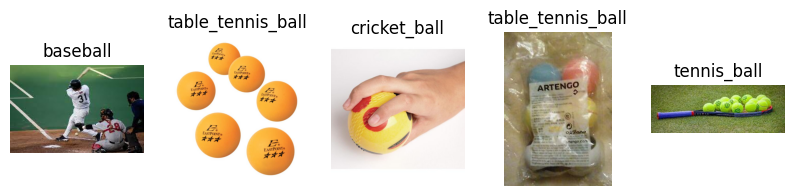

In [162]:
# Load images and labels from train and test folders
original_images, original_labels = load_images("data/train")
test_images, test_labels = load_images("data/test")

display_samples(original_images, original_labels)


### Circle Detection Example

Image 1410
(196, 257, 3)


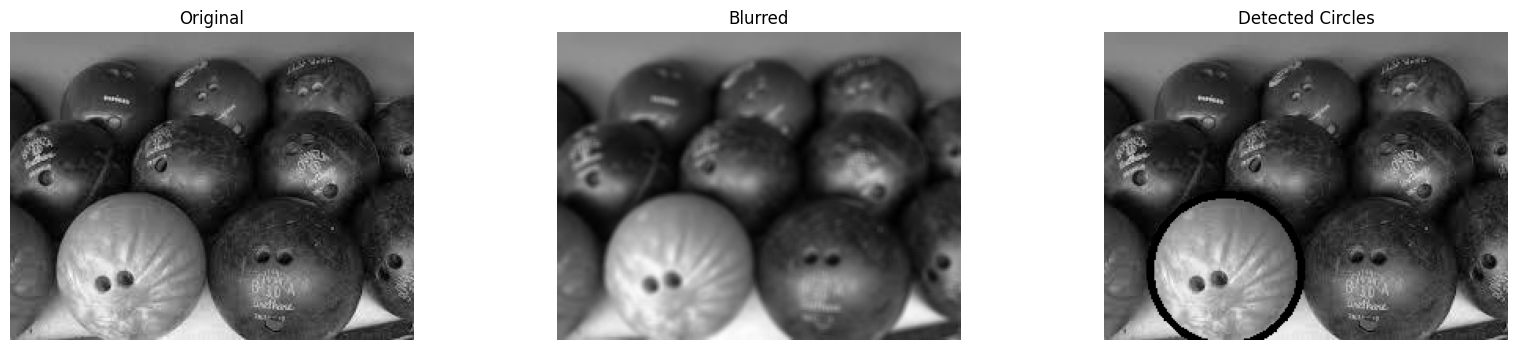

array([[ 77, 151,  48]])

In [243]:
rand = np.random.randint(len(original_images))
# rand = 3973
print(f"Image {rand}")
print(original_images[rand].shape)
detect_circles(original_images[rand], show=True, max_circles=5)


### Preprocess images

- circles detected
- images cropped to circles
- images downsampled to _image_size_


In [16]:
processed_images, processed_labels = preprocess_images(original_images, original_labels)
display_samples(processed_images, processed_labels)

  2%|▏         | 135/5632 [00:05<03:49, 24.00it/s]


KeyboardInterrupt: 

### Load Training Images

- These images were previously processed and saved to disk
- images downsampled to _image_size_

100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


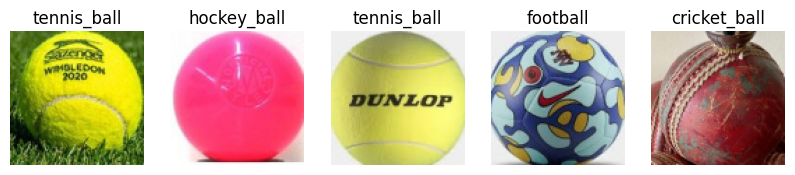

In [350]:
ball_images, ball_labels = load_images("data/color_ball")
downsampled_images, downsampled_labels = downsample_images(ball_images, ball_labels)
display_samples(downsampled_images, downsampled_labels)

### Diversify Images and mask them to circles

- Randomly rotate and flip the images

  0%|          | 0/2758 [00:00<?, ?it/s]

100%|██████████| 2758/2758 [00:09<00:00, 286.91it/s]


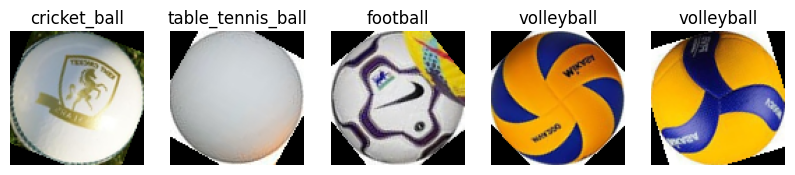

In [351]:
# diversify the images
diversified_images, diversified_labels = diversify_images(downsampled_images, downsampled_labels, times=2)
display_samples(diversified_images[len(downsampled_images):], diversified_labels[len(downsampled_labels):])

### CNN

In [352]:
import keras
import keras.models
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.optimizers import Adam


def train_model(input_x: np.ndarray, input_y: np.ndarray, shape: Tuple[int, int], epochs: int) -> Tuple[keras.Sequential, keras.callbacks.History]:
    input_x = np.array(input_x)
    # Normalize the images
    # input_x = input_x.astype('float32') / 255.0

    # Convert string labels to numerical values
    input_y = label_encoder.fit_transform(input_y)
    class_weights = compute_class_weight('balanced', classes=np.unique(input_y), y=input_y)
    class_weights = dict(enumerate(class_weights))
    input_y = to_categorical(input_y)
    num_classes = input_y.shape[1]

    train_images, val_images, train_labels, val_labels = train_test_split(input_x, input_y, test_size=0.2, random_state=42)
    train_images = circle_mask_images(train_images)
    val_images = circle_mask_images(val_images)

    model = keras.Sequential()

    # convolutional layer 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=shape, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 3
    model.add(Conv2D(96, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 4
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 5
    model.add(Conv2D(160, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # flatten the output
    model.add(Flatten())

    # fully connected layer
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # output layer
    model.add(Dense(num_classes, activation='softmax'))

    # compile the model and print summary
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

    # datagen = ImageDataGenerator(
    #     rotation_range=30,
    #     width_shift_range=0.1,
    #     height_shift_range=0.1,
    #     # shear_range=0.2,
    #     # zoom_range=0.2,
    #     # horizontal_flip=True,
    #     fill_mode='nearest'
    # )

    # train_images = np.expand_dims(train_images, axis=-1)
    # Fit the generator to your training data
    # datagen.fit(train_images)

    # train the model
    history = model.fit(
        train_images, train_labels,
        epochs=epochs,
        validation_data=(val_images, val_labels),
        class_weight=class_weights,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )
    model.summary()
    return model, history


label_encoder.fit(diversified_labels)
model, history = train_model(diversified_images, diversified_labels, downsampled_images[0].shape, epochs)
model.save("ball_cnn.keras")

c:\Users\jamie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 147ms/step - accuracy: 0.2744 - loss: 3.2511 - val_accuracy: 0.3819 - val_loss: 2.8073
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 0.4617 - loss: 2.4845 - val_accuracy: 0.4097 - val_loss: 3.0213
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 0.5405 - loss: 2.1904 - val_accuracy: 0.4127 - val_loss: 2.8140
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 0.5631 - loss: 2.0698 - val_accuracy: 0.5523 - val_loss: 2.3460
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - accuracy: 0.6083 - loss: 1.9031 - val_accuracy: 0.4586 - val_loss: 2.5493
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - accuracy: 0.6200 - loss: 1.7834 - val_accuracy: 0.6012 - val_loss: 1.9634
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - accuracy: 0.6532 - loss: 1.6802 - val_accuracy: 0.5825 - val_loss: 2.0815
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 0.6703 - loss: 1

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_158 (Conv2D)             │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_196         │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_158               │ (None, 48, 48, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_196 (Dropout)           │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_197         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_159               │ (None, 24, 24, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_197 (Dropout)           │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 24, 24, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_198         │ (None, 24, 24, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_160               │ (None, 12, 12, 96)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_198 (Dropout)           │ (None, 12, 12, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 12, 12, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_199         │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_161               │ (None, 6, 6, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_199 (Dropout)           │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_162 (Conv2D)             │ (None, 6, 6, 160)      │       184,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_200         │ (None, 6, 6, 160)      │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_162               │ (None, 3, 3, 160)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_200 (Dropout)           │ (None, 3, 3, 160)      │             

 Total params: 2,231,011 (8.51 MB)

 Trainable params: 743,179 (2.84 MB)

 Non-trainable params: 1,472 (5.75 KB)

 Optimizer params: 1,486,360 (5.67 MB)

### Application

69


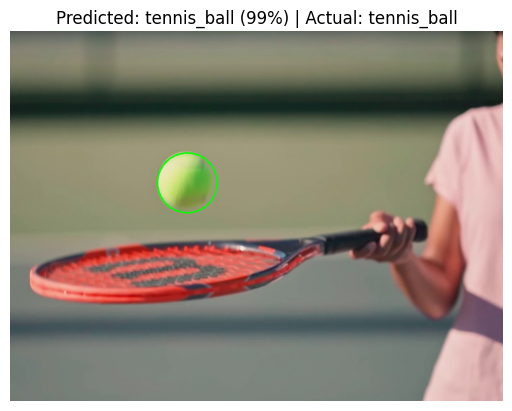

In [349]:
from keras.saving import load_model


def identify_ball(model: keras.Sequential, image: np.ndarray) -> Tuple[np.ndarray, int, int, np.ndarray, np.ndarray]:
    # Preprocess the image
    circles = detect_circles(image, show=False)
    cropped_images = crop_to_circle(image, circles)
    if not cropped_images:
        return None, "No ball detected", 0, None

    cropped_images, _ = downsample_images(cropped_images)
    cropped_images = circle_mask_images(cropped_images)
    # cropped_images = cropped_images.astype('float32') / 255.0
    if cropped_images.size == 0:
        return None, None, None, None, None

    predictions = model.predict(cropped_images, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_prob = np.max(predictions, axis=1)

    # Get the most confident prediction
    best_idx = np.argmax(predicted_prob)
    best_class = label_encoder.inverse_transform([predicted_class[best_idx]])[0]
    best_prob = predicted_prob[best_idx]

    return cropped_images[best_idx], best_class, round(best_prob * 100), circles[best_idx], np.delete(circles, best_idx, axis=0)

loaded_model = load_model("ball_cnn.keras")

# Example usage
rand = np.random.randint(len(b_images))
# rand = 1332
print(rand)
test_image = b_images[rand]
test_label = b_labels[rand]
ball_image, ball_label, prob, best_circle, other_circles = identify_ball(loaded_model, test_image)
if ball_image is not None:
    image_with_circle = test_image.copy()
    cv2.circle(image_with_circle, (best_circle[0], best_circle[1]), best_circle[2], (0, 255, 0), 2)
    for (x, y, r) in other_circles:
        cv2.circle(image_with_circle, (x, y), r, (0, 0, 255), 2)
else:
    print("No ball detected")

plt.imshow(cv2.cvtColor(image_with_circle, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {ball_label} ({prob}%) | Actual: {test_label}")
plt.axis('off')
plt.show()

In [ ]:
def draw_and_save_circles(images: List[np.ndarray], folder: str) -> None:
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    images_with_index = list(enumerate(images))
    for i, image in tqdm(images_with_index):
        _, label, _, best_circle, other_circles = identify_ball(loaded_model, image)
        image_with_circle = image.copy()
        if best_circle is not None:
            cv2.circle(image_with_circle, (best_circle[0], best_circle[1]), best_circle[2], (0, 255, 0), 2)
            for (x, y, r) in other_circles:
                cv2.circle(image_with_circle, (x, y), r, (255, 0, 0), 2)
        save_path = os.path.join(folder, f"{i}-pred-{label}.jpg")
        cv2.imwrite(save_path, image_with_circle)


draw_and_save_circles(test_images, "data/circles")

In [316]:
b_images, b_labels = load_images("data/optical_flow")

100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


In [280]:
def interpolate_images(images: List[np.ndarray], target_size: Tuple[int, int] = (96, 96)) -> List[np.ndarray]:
    interpolated_images = []
    for img in images:
        if img.shape[0] < target_size[0] or img.shape[1] < target_size[1]:
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        interpolated_images.append(img)
    return interpolated_images

# Example usage
interpolated_images = interpolate_images(b_images)

### Get Best Circle

100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


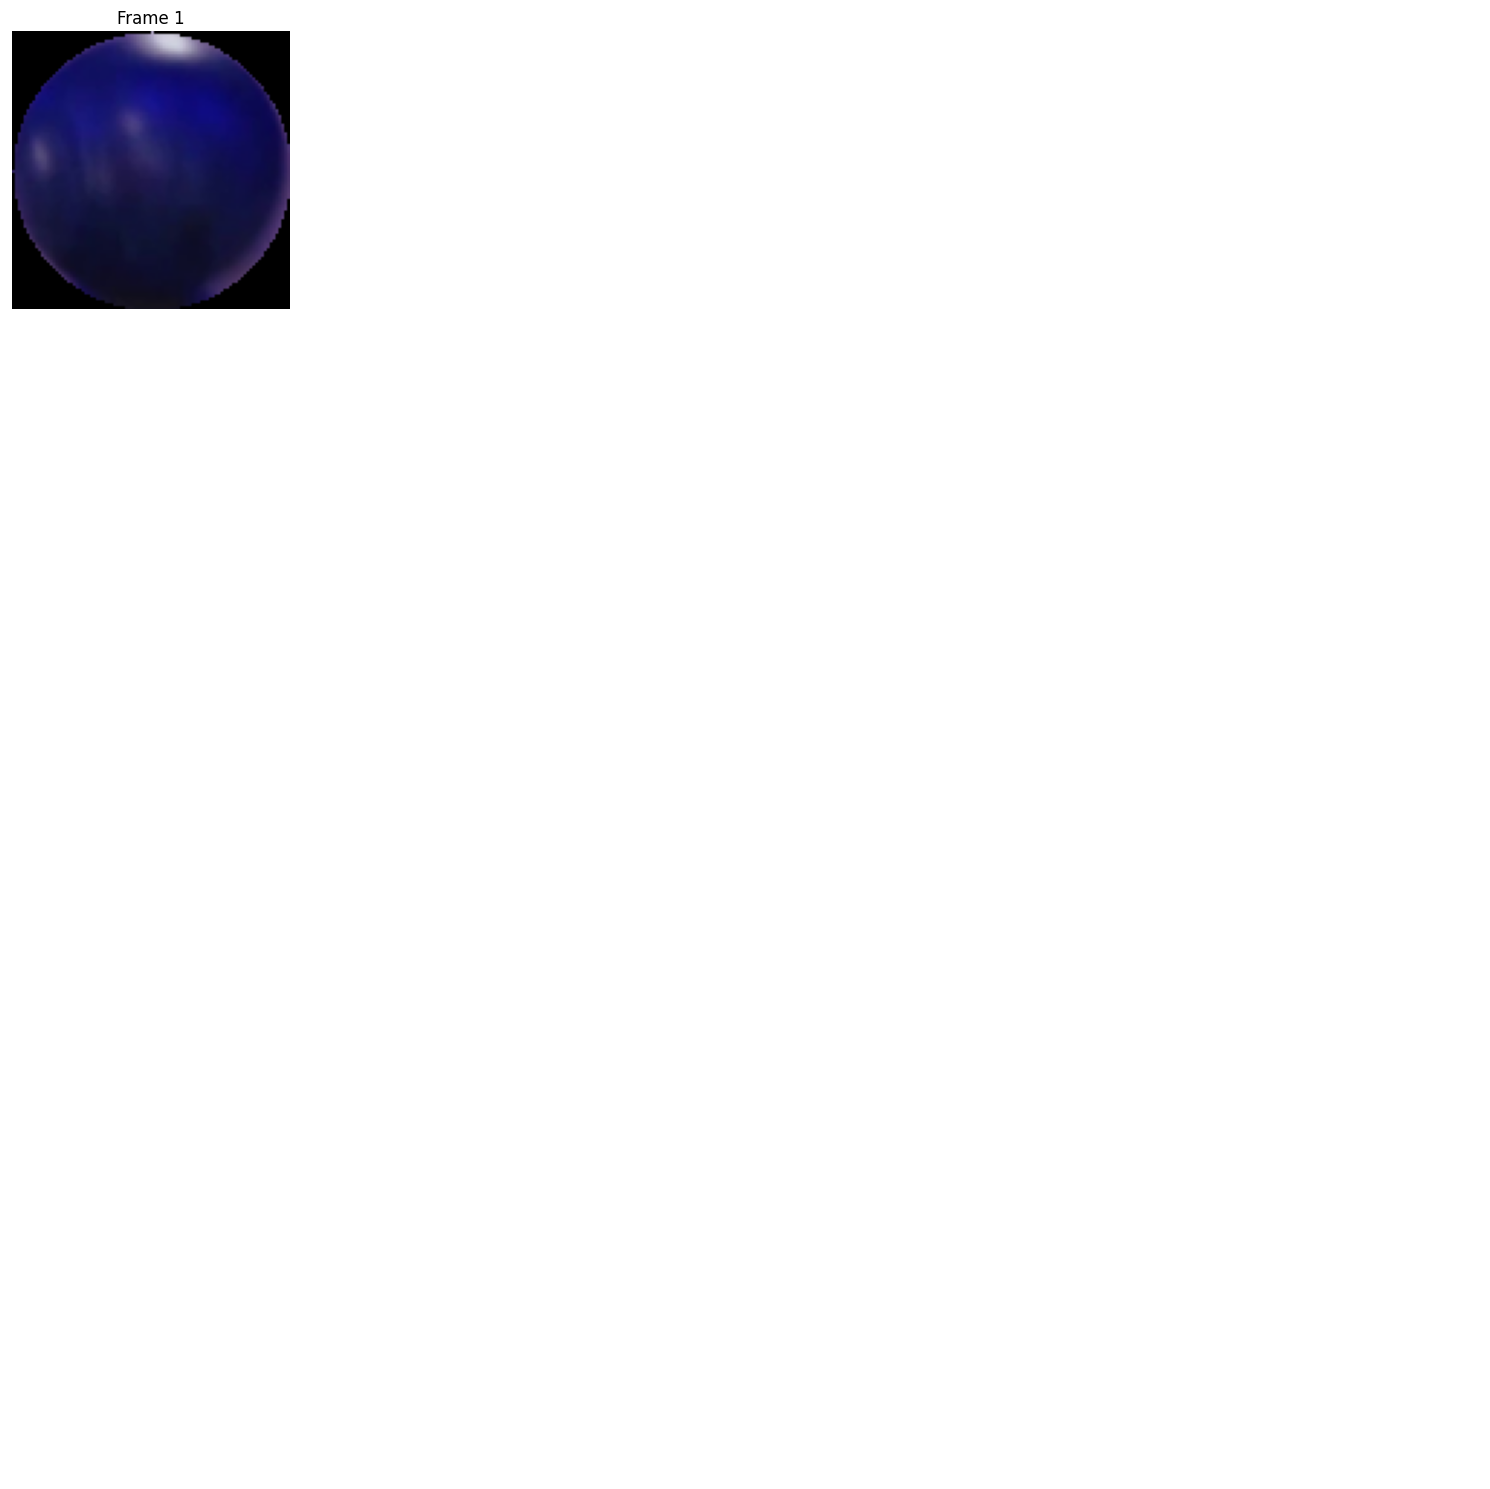

In [286]:
def get_best_circles(model: keras.Sequential, images: List[np.ndarray]) -> Tuple[np.ndarray, int, int, np.ndarray, np.ndarray]:
    grouped_images, _ = process_images(images, ["" * len(images)])
    best_circles = []
    for group in tqdm(grouped_images):
        predictions = model.predict(group, verbose=0)
        predicted_prob = np.max(predictions, axis=1)
        best_idx = np.argmax(predicted_prob)
        best_circles.append(group[best_idx])
    return np.array(best_circles)

loaded_model = load_model("ball_cnn.keras")
best_circles = get_best_circles(loaded_model, interpolated_images)

# Display the first masked frame as an example
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    if i < len(best_circles):
        ax.imshow(cv2.cvtColor(best_circles[i], cv2.COLOR_BGR2RGB))
        ax.set_title(f"Frame {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()


### Processing test images for evaluation


In [353]:
from tensorflow.keras.utils import to_categorical

loaded_model = load_model("ball_cnn.keras")
x_test_grouped, y_test = process_images(test_images, test_labels)
# x_test_grouped, y_test = process_images(b_images, b_labels)
y_test = label_encoder.fit_transform(y_test)
y_test = to_categorical(y_test, num_classes=11)
x_test = []
for group in tqdm(x_test_grouped):
    predictions = model.predict(group, verbose=0)
    predicted_prob = np.max(predictions, axis=1)
    best_idx = np.argmax(predicted_prob)
    x_test.append(group[best_idx])

100%|██████████| 1030/1030 [01:31<00:00, 11.21it/s]


Test Loss: 2.7660
Test Accuracy: 0.5650
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.7385    0.6316    0.6809        76
           1     0.6386    0.7681    0.6974        69
           2     0.5333    0.4167    0.4678        96
           3     0.5301    0.5500    0.5399        80
           4     0.7900    0.6810    0.7315       116
           5     0.5630    0.5468    0.5547       139
           6     0.4554    0.5484    0.4976        93
           7     0.5161    0.3516    0.4183        91
           8     0.4299    0.4894    0.4577        94
           9     0.5930    0.5862    0.5896        87
          10     0.5082    0.6966    0.5877        89

    accuracy                         0.5650      1030
   macro avg     0.5724    0.5697    0.5657      1030
weighted avg     0.5730    0.5650    0.5640      1030



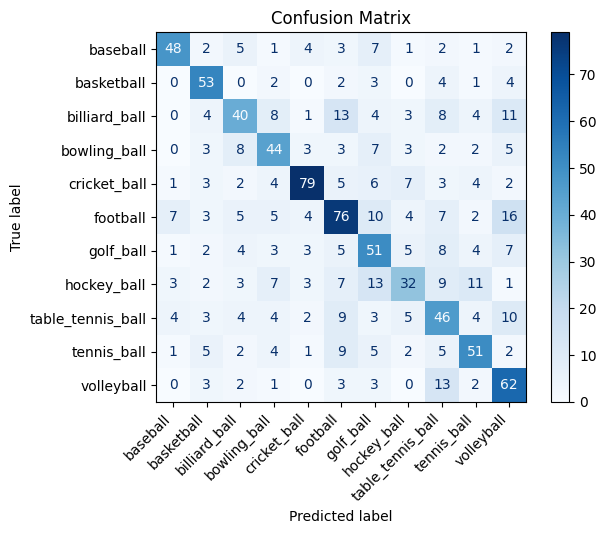

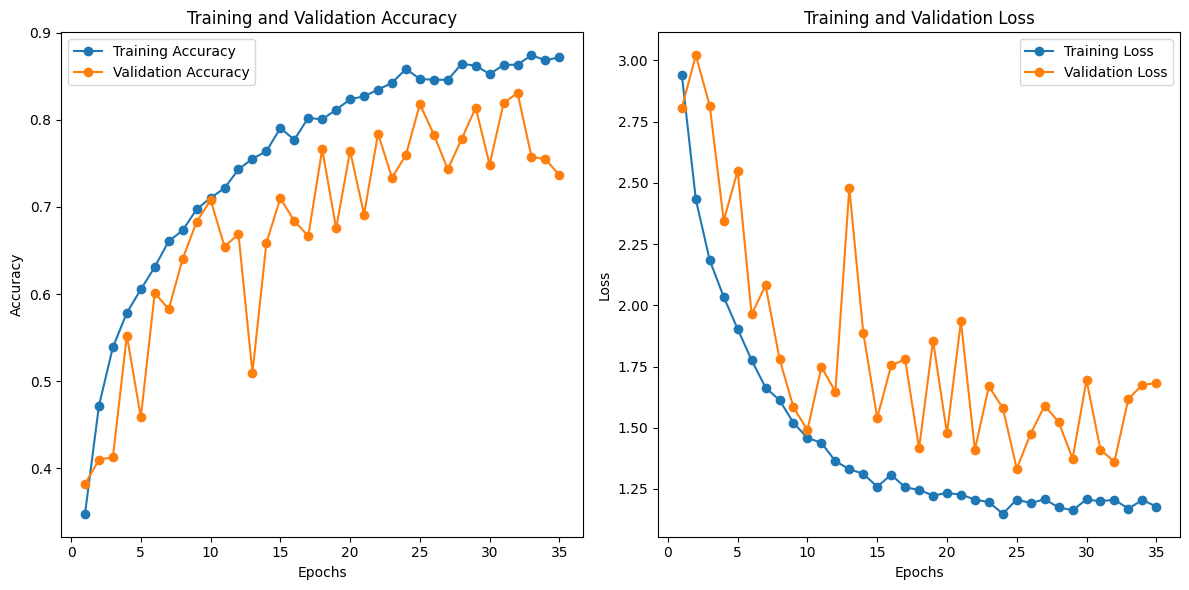

In [354]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


def evaluate_model(model: keras.Sequential, x_test: np.ndarray, y_test: np.ndarray) -> Tuple[float, float]:
    x_test = np.expand_dims(x_test, axis=-1)
    # x_test = x_test.astype('float32') / 255.0

    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predict the labels for the test data
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Generate classification report
    report = classification_report(y_true, y_pred, digits=4)
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=45, ha='right')
    plt.title("Confusion Matrix")
    plt.show()

    # Training and validation loss/accuracy plots
    history_dict = history.history  # Assuming `history` is the training history object
    epochRange = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(12, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochRange, history_dict['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochRange, history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochRange, history_dict['loss'], label='Training Loss', marker='o')
    plt.plot(epochRange, history_dict['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


evaluate_model(loaded_model, x_test, y_test)


### Hyperparameter Tuning

In [74]:
import pandas as pd
import keras
from keras.optimizers import Adam, SGD, RMSprop
import keras.models
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
from tqdm import tqdm


def create_model(optimizer, learning_rate, depth, num_classes):
    model = keras.Sequential()
    model.add(Input(shape=(96, 96, 3)))
    
    # adjust the depth of the model
    for i in range(depth):
        model.add(Conv2D(32 * (i + 1), (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        # check that dimensions are large enough for pooling
        if model.output_shape[1] >= 2 and model.output_shape[2] >= 2:
            model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))
    
    # choose optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)

    
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model


def train_and_evaluate(x_train, y_train, x_val, y_val, optimizer, lr, depth, num_classes, epochs=20):
    model = create_model(optimizer, lr, depth, num_classes)
    model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_val, y_val), verbose=0)
    _, test_accuracy = model.evaluate(x_val, y_val, verbose=0)
    return test_accuracy, optimizer, lr, depth


def run_tuning(input_x, input_y):
    # Convert string labels to numerical values
    input_y = label_encoder.fit_transform(input_y)
    class_weights = compute_class_weight('balanced', classes=np.unique(input_y), y=input_y)
    class_weights = dict(enumerate(class_weights))
    input_y = to_categorical(input_y)
    num_classes = input_y.shape[1]

    train_images, val_images, train_labels, val_labels = train_test_split(input_x, input_y, test_size=0.2, random_state=42)
    train_images = circle_mask_images(train_images)
    val_images = circle_mask_images(val_images)

    optimizers = ['adam', 'sgd', 'rmsprop']
    learning_rates = [0.001, 0.01, 0.0001]
    depths = [3, 4, 5]

    results = []
    total_tasks = len(optimizers) * len(learning_rates) * len(depths)
    with tqdm(total=total_tasks) as progress:
        for optimizer in optimizers:
            for lr in learning_rates:
                for depth in depths:
                    test_accuracy, optimizer, lr, depth = train_and_evaluate(train_images, train_labels, val_images, val_labels, optimizer, lr, depth, num_classes, epochs=20)
                    results.append({
                        'Optimizer': optimizer,
                        'Learning Rate': lr,
                        'Depth': depth,
                        'Test Accuracy': test_accuracy
                    })
                    progress.update(1)


    results_df = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False)
    results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
    print(results_df)


run_tuning(diversified_images, diversified_labels)

100%|██████████| 27/27 [1:57:50<00:00, 261.88s/it]

   Optimizer  Learning Rate  Depth  Test Accuracy
2       adam         0.0010      5       0.672445
1       adam         0.0010      4       0.658759
0       adam         0.0010      3       0.656934
19   rmsprop         0.0010      4       0.620438
18   rmsprop         0.0010      3       0.593066
4       adam         0.0100      4       0.532847
6       adam         0.0001      3       0.528285
12       sgd         0.0100      3       0.501825
5       adam         0.0100      5       0.500912
25   rmsprop         0.0001      4       0.498175
7       adam         0.0001      4       0.480839
24   rmsprop         0.0001      3       0.480839
14       sgd         0.0100      5       0.471715
3       adam         0.0100      3       0.467153
22   rmsprop         0.0100      4       0.464416
26   rmsprop         0.0001      5       0.447993
9        sgd         0.0010      3       0.441606
21   rmsprop         0.0100      3       0.432482
13       sgd         0.0100      4       0.412409
